# DETERMINE CORRECT FLIP/ROTATION OF GAIN IMAGE
#### Hypothesis: 
If the gain is correctly applied to individual images when they are averaged together, they will be flat (low variance) as the underlying defects are reversed. Also the reciprical of the running average should converge to be most similar to the gain that is correctly transformed.

#### Method: 
READ in frames from TIF movies and average.  As the frames are added, they are multiplied with the GAIN image (but with different transformations) to determine which gain is giving the best correction.

#### Gains: 
The gains have the following transformations (1) no gain, (2) the original untransformed gain, (3) flipped in X (flip left-right), (4) flipped in Y (flipped up/down), and (5) rotated 180 degrees. I don´t think rot90 or rot270 are valid as the K3 sensor is rectangular, and I can see that the gain is in the same orientation as the movies.

The gain is saved as a DM4, so to use in cryosparc/relion it needs to be converted to MRC. We test 4 ways (cases) to convert the gain.  Note that any one of these software packages can flip or rotate images when they read/write the MRC.
Cases (conversion methods):
cp 'K3-18210046 Gain Ref. x1.m1.kv[300].dm4' K3-18210046GainRef.x1.m1.kv300.dm4
1) Python: read DM4 (ncempy or hyperspy) - > rebin wih mean (ncempy) -> save to MRC (mrcfile)
2) imod: dm2mrc K3-18210046GainRef.x1.m1.kv300.dm4 gain_imod.mrc  ; newstack -in gain_imod.mrc -ou gain_imod1bin2.mrc -bi 2
3) imod + relion: dm2mrc K3-18210046GainRef.x1.m1.kv300.dm4 gain_imod.mrc ; relion_image_handler --i gain_imod.mrc --o gain_imod2bin2.mrc  --angpix 1 --rescale_angpix 2
4) eman2: e2proc2d.py K3-18210046GainRef.x1.m1.kv300.dm4 gain_emanbin2.mrc --meanshrink 2

#### Assaying gain correction
1) Compare Visually:  look at the final gain corrected running average. Expect a flat image
2) Compare Standard Deviation (Std Dev) or median absolute deviation (MAD) in gain corrected running average. Expect the gain correct image to have lower varience than the non-gain corrected. Also, a wrong gain should increase variance as we impose a 2nd artificial pattern.
3) Compare the running average (not gain corrected) to the transformed gains using the Structural Similarity index (SSIM). Expect the running average (reciprocal) to converge to the correct gain image and be less similar to the wrong gain images.

#### Notes on method
1) According to this post https://groups.google.com/g/warp-em/c/-fOnQ34VMO8/m/g8d6C8T6AwAJ K2/K3 gains are multiplied to the raw images
2) According to this post (not sure I understand), flipping and rotating gain is required because camera can be installed in several orientations https://discuss.cryosparc.com/t/flipping-and-rotating-gain-reference/9877/5?u=frozenfas
3) According to this post, file.imread() opens tiffs like cryosparc https://discuss.cryosparc.com/t/cryosparc-tools-open-tiff/13255/6?u=frozenfas
4) According to this post, RELION/Motioncoor read tiff differently (flipY), accounting for the need to flip differently if you are using RELION/Motioncoor or CS https://discuss.cryosparc.com/t/flipping-and-rotating-gain-reference/9877/2?u=frozenfas
NOTE: The notebook I used in the test is here.  This code is not well organised. it would be better to organise it in 3D arrays to make it cleaner.  Also, see notes, but there are several places to make it more efficient, but it is mostly i/o limited, so I am not so worried.

In [2]:
# **************************************************************************
# *
# * Authors:    Sean Connell (sean.connell@gmail.com)
# *
# * Structural Biology of Cellular Machines
# *
# **************************************************************************

# Test CASE 1 (python)

In [4]:
#import starfile
import mrcfile
import pandas as pd
import argparse
import os, glob, re
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tifffile # confirmed by CS-team this is same orientation as CS
import ncempy.io as nio
from ncempy.algo import rebin 
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

#https://scikit-image.org/docs/stable/api/skimage.metrics.html#

/tmp/ipykernel_34067/3779422901.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
# input file name 
glob_file = 'Movies/*_Fractions.tiff'
n_mics = 2000                     # number of movies to average.  
update_freq = 20                 # update stats on the running average every x iterations
n_frames = 40
 
fnDmGain = 'K3-18210046GainRef.x1.m1.kv300.dm4'
#fnMrcGain = 'gain_emanbin2.mrc'


In [6]:
# note I have no idea if ncempy flips any axis when opening... it works the same as ncempy
SRGain = nio.read(fnDmGain)
print(SRGain['data'].shape) # the shape of the data
DataGain = rebin(SRGain['data'], 2, funcType='mean')
print(DataGain.shape)
del SRGain # remove this big array

(8184, 11520)
(4092, 5760)


In [7]:
# read in files and modify/flip as required
#MrcGain = mrcfile.open(fnMrcGain, mode='r+') # unmodified  gain (just bined and converted as discribed above)
#DataGain = MrcGain.data
#del MrcGain
print (DataGain.shape)

DataGainflr = np.fliplr(DataGain) #  gain left right flip ( =x = flipped columns)
DataGainfud = np.flipud(DataGain) # gain up down flip ( =y = flipped rows )
DataGainrot = np.rot90(np.rot90(DataGain)) # gain rotate 180 same as both fliplr and flipud

# I dont think rot90 or rot270 are valid as the K3 sensor is rectangular and I can see that the gain  
# is in same orintation as movies



(4092, 5760)


In [8]:
mic_list = glob.glob(glob_file)
print(len(mic_list))

19615


In [9]:
# MAD = median absolute deviation https://stackoverflow.com/questions/60092641/mad-results-differ-in-pandas-scipy-and-numpy
# less senstenve to outliers than std
def get_stats(a):
    m = np.mean(a)
    std = np.std(a)
    mad = np.median(np.absolute(a - np.median(a)))
    return m, std, mad
def get_ssim(im_avg,im_gain):
    ssim_vs_avg = ssim(im_gain, im_avg, data_range=im_avg.max() - im_avg.min())
    return ssim_vs_avg


# initialize zero array to accumilate running sum of frames  
# use float64. I get wrap around errors if  I use float32
# if I save to MRC remember to use .astype(np.float32)


array_none = np.zeros(shape=(4092, 5760), dtype=np.float64)
array_gain = np.zeros(shape=(4092, 5760), dtype=np.float64)
array_gainflr = np.zeros(shape=(4092, 5760), dtype=np.float64)
array_gainfud = np.zeros(shape=(4092, 5760), dtype=np.float64)
array_gainrot = np.zeros(shape=(4092, 5760), dtype=np.float64)

# initialize zero array to store statistics every n-iterations
# ncol=12 becasue we store n_movie, n_frames, and (mean, std and mad) for each gain (= 15)
# nrow is the quotient from the number of movies diveded by the update freq
array_stats = np.zeros(shape=(n_mics // update_freq, 21)) 

for i in tqdm.tqdm(range(n_mics)):
    #print(mic_list[i])
    # print(i)
    a = tifffile.imread(mic_list[i])
    # note Sean it is ineficent this loop it would be better to add all frames then mulitiply
    # becasue x(a+b) = ax+bx.  Better luck next time
    for f in range(n_frames):
        #print(i,f)
        array_none += a[f]
        array_gain += (a[f]* DataGain)
        array_gainflr += (a[f] * DataGainflr )
        array_gainfud += (a[f] * DataGainfud )
        array_gainrot += (a[f] * DataGainrot )
    if (i % update_freq == 0): # will update ever iteraction that is divible by 10 (1,11,21 movie)
        
        t = (i+1) * n_frames
        # the arrays are the running total, therefore divide by number of frames to get current average
        m_none, std_none, mad_none = get_stats(array_none / t)
        m_gain, std_gain, mad_gain = get_stats(array_gain / t)
        m_gainflr, std_gainflr, mad_gainflr = get_stats(array_gainflr / t)
        m_gainfud, std_gainfud, mad_gainfud = get_stats(array_gainfud / t)
        m_gainrot, std_gainrot, mad_gainrot = get_stats(array_gainrot / t)
        # compare running average to orginal gain
        # I expect the running average to get more similar to the correct gain as more
        # movies are added

        # the running average is the recipricol of a multiplative gain so we switch 
        calculatedGain = np.reciprocal((array_none / t))
        
        ssim_gain = get_ssim(calculatedGain, DataGain)
        ssim_gainflr = get_ssim(calculatedGain, DataGainflr)
        ssim_gainfud = get_ssim(calculatedGain, DataGainfud)
        ssim_gainrot = get_ssim(calculatedGain, DataGainrot)

        #print(ssim_gain)
        
        # strore the stats
        array_stats[int(i / update_freq)]= [i, t, m_none, std_none, mad_none, \
                         m_gain, std_gain, mad_gain, ssim_gain, \
                         m_gainflr, std_gainflr, mad_gainflr, ssim_gainflr, \
                         m_gainfud, std_gainfud, mad_gainfud, ssim_gainfud, \
                         m_gainrot, std_gainrot, mad_gainrot, ssim_gainrot ]


# the arrays are the running total, therefore divide by number of frames to get average
t = n_mics*n_frames
array_none /= t
array_gain /= t
array_gainflr /= t
array_gainfud /= t
array_gainrot /= t       


100%|█████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [6:16:27<00:00, 11.29s/it]


In [10]:
print(array_stats.shape)
#print(array_stats)

(100, 21)


Variation Measure
 NONE (m/std): 0.5778756357722047, 0.015921151608612124
 GAIN (m/std): 0.5822644918148415, 0.01912909563175689
 GAINFLR (m/std): 0.5820832775755119, 0.012440748252822757
 GAINFUD (m/std): 0.5822600079822475, 0.018996669891222343
 GAINROT (m/std): 0.582249419136307, 0.0186747240230858
Simularity Measure
 GAIN (SSIM): 0.6561902717478691
 GAINFLR (SSIM): 0.7918403730394669
 GAINFUD (SSIM): 0.6559448587728199
 GAINROT (SSIM): 0.6567057489223935


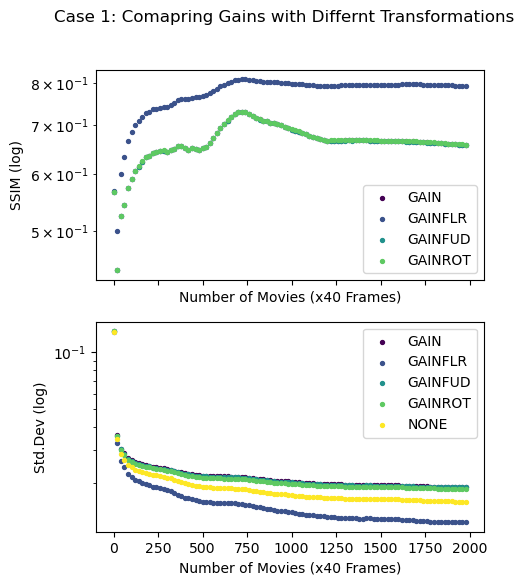

In [11]:
# print out final stats. it should be the similar as those stored in array_states but maybe not the same 
# the number of movies might not be a perfect multiple of the update freq (who is the sick freak who uses a wierd number of movies)
m_none, std_none, mad_none = get_stats(array_none )
m_gain, std_gain, mad_gain = get_stats(array_gain )
m_gainflr, std_gainflr, mad_gainflr = get_stats(array_gainflr )
m_gainfud, std_gainfud, mad_gainfud = get_stats(array_gainfud )
m_gainrot, std_gainrot, mad_gainrot = get_stats(array_gainrot )

calculatedGain = np.reciprocal(array_none)

ssim_gain = get_ssim(calculatedGain ,DataGain)
ssim_gainflr = get_ssim(calculatedGain, DataGainflr)
ssim_gainfud = get_ssim(calculatedGain, DataGainfud)
ssim_gainrot = get_ssim(calculatedGain, DataGainrot)

print('Variation Measure')
print(f' NONE (m/std): {m_none}, {std_none}' )
print(f' GAIN (m/std): {m_gain}, {std_gain}' )
print(f' GAINFLR (m/std): {m_gainflr}, {std_gainflr}' )
print(f' GAINFUD (m/std): {m_gainfud}, {std_gainfud}' )
print(f' GAINROT (m/std): {m_gainrot}, {std_gainrot}' )
print('Simularity Measure')
print(f' GAIN (SSIM): {ssim_gain}' )
print(f' GAINFLR (SSIM): {ssim_gainflr}' )
print(f' GAINFUD (SSIM): {ssim_gainfud}' )
print(f' GAINROT (SSIM): {ssim_gainrot}' )


# colormaps = https://matplotlib.org/stable/gallery/color/colormap_reference.html
n = 5
colors = plt.cm.viridis(np.linspace(0,1,n))

fig, axs = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(5,6)) #sharey=True
fig.suptitle('Case 1: Comapring Gains with Differnt Transformations')
axs[0].set_xlabel('Number of Movies (x40 Frames)')
axs[0].set_ylabel('SSIM (log)')
axs[0].set_yscale("log")
axs[0].scatter(x=array_stats[0:, 0], y=array_stats[0:, 8], label='GAIN', s=8, color=colors[0])
axs[0].scatter(x=array_stats[0:, 0], y=array_stats[0:, 12], label='GAINFLR',s=8, color=colors[1])
axs[0].scatter(x=array_stats[0:, 0], y=array_stats[0:, 16], label='GAINFUD',s=8, color=colors[2])
axs[0].scatter(x=array_stats[0:, 0], y=array_stats[0:, 20], label='GAINROT',s=8, color=colors[3])
axs[0].legend(loc="lower right")



axs[1].set_xlabel('Number of Movies (x40 Frames)')
axs[1].set_ylabel('Std.Dev (log)')
axs[1].set_yscale("log")
axs[1].scatter(x=array_stats[0:, 0], y=array_stats[0:, 6], label='GAIN', s=8, color=colors[0])
axs[1].scatter(x=array_stats[0:, 0], y=array_stats[0:, 10], label='GAINFLR',s=8, color=colors[1])
axs[1].scatter(x=array_stats[0:, 0], y=array_stats[0:, 14], label='GAINFUD', s=8, color=colors[2])
axs[1].scatter(x=array_stats[0:, 0], y=array_stats[0:, 18], label='GAINROT', s=8, color=colors[3])
axs[1].scatter(x=array_stats[0:, 0], y=array_stats[0:, 3], label='NONE', s=8, color=colors[4])
axs[1].legend(loc="upper right")


Text(0.5, 1.0, 'WITH GAIN ROT180')

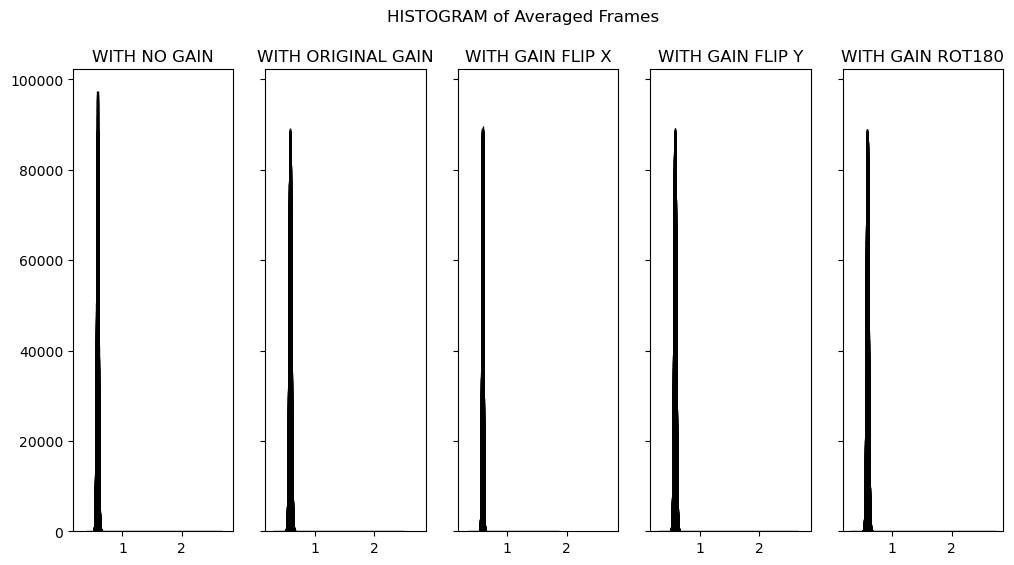

In [12]:
fig, axs = plt.subplots(1,5,sharex=True, sharey=True,figsize=(12,6))
fig.suptitle('HISTOGRAM of Averaged Frames')
axs[0].hist(array_none.ravel(), bins='auto', fc='k', ec='k')
axs[0].set_title('WITH NO GAIN')
axs[1].hist(array_gain.ravel(), bins='auto', fc='k', ec='k')
axs[1].set_title('WITH ORIGINAL GAIN')
axs[2].hist(array_gainflr.ravel(), bins='auto', fc='k', ec='k')
axs[2].set_title('WITH GAIN FLIP X')
axs[3].hist(array_gainfud.ravel(), bins='auto', fc='k', ec='k')
axs[3].set_title('WITH GAIN FLIP Y')
axs[4].hist(array_gainrot.ravel(), bins='auto', fc='k', ec='k')
axs[4].set_title('WITH GAIN ROT180')


Text(0.5, 1.0, 'WITH GAIN ROT180')

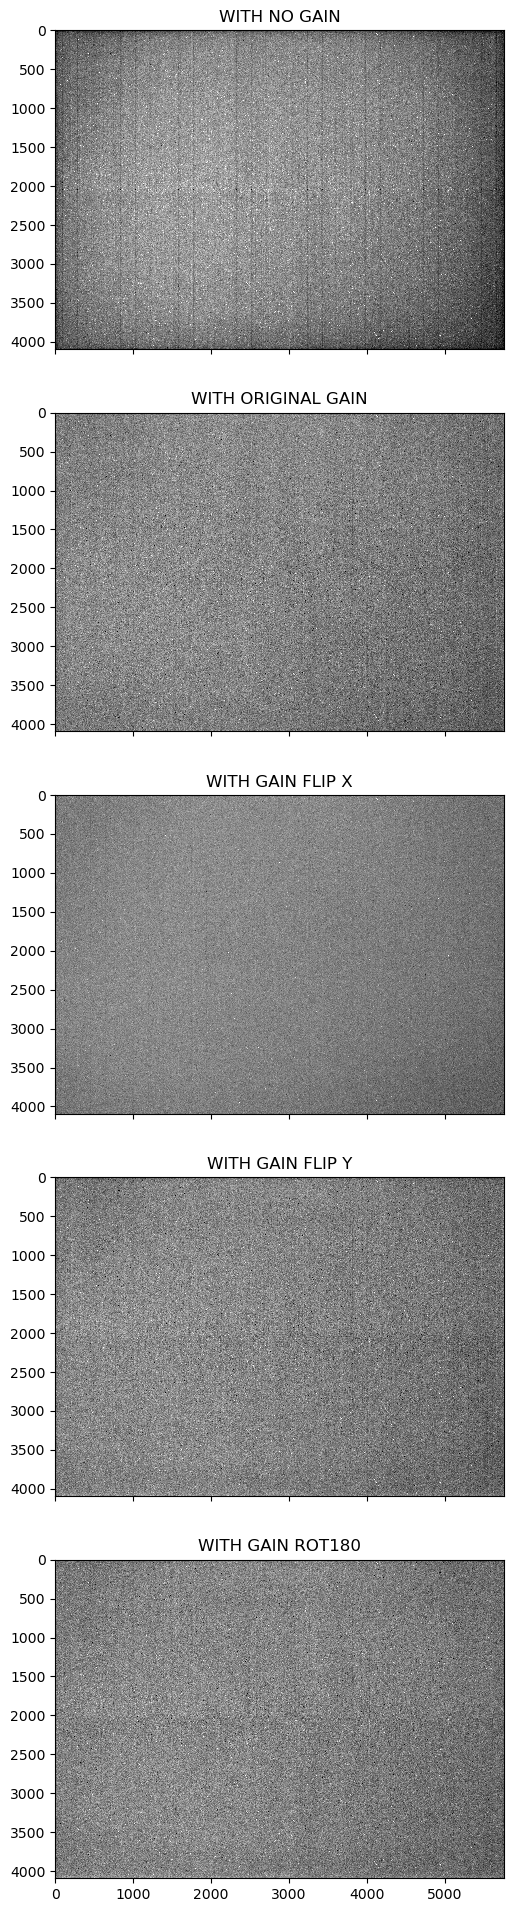

In [13]:
fig, axs = plt.subplots(nrows=5,ncols=1, sharex=True, sharey=True,figsize=(12,24))
axs[0].imshow(array_none-np.mean(array_none)+1,interpolation='none', cmap='grey', clim=(0.94, 1.06) ) 
axs[0].set_title('WITH NO GAIN')
axs[1].imshow(array_gain-np.mean(array_gain)+1,interpolation='none', cmap='grey', clim=(0.91, 1.09) ) #clim=(0.45, 0.7)
axs[1].set_title('WITH ORIGINAL GAIN')
axs[2].imshow(array_gainflr-np.mean(array_gainflr)+1,interpolation='none', cmap='grey', clim=(0.91, 1.09) ) #clim=(0.5, 0.7)
axs[2].set_title('WITH GAIN FLIP X')
axs[3].imshow(array_gainfud-np.mean(array_gainflr)+1,interpolation='none', cmap='grey', clim=(0.91, 1.09) ) #clim=(0.5, 0.7)
axs[3].set_title('WITH GAIN FLIP Y')
axs[4].imshow(array_gainrot-np.mean(array_gainrot)+1,interpolation='none', cmap='grey', clim=(0.91, 1.09) ) #clim=(0.5, 0.7)
axs[4].set_title('WITH GAIN ROT180')


#plt.savefig("compare_brem_relion_sean_gaincorrection.pdf", format="pdf", bbox_inches="tight")

###  CONCLUSIONS
-In case 1 (pyhton to read DM4, bin and save as MRC) the best gain correction is observed when the gain is flipped left to right (or flipx).
- using 2000 movies is overkill I think 250 is fine.
- I think the SSIM is a good measure and probably suficent. Maybe can even improve by matching the mean of the array to the gains
- The visual method is not as good as different monitors intruduce differnt visual effects. ALso the range you display makes big effect. 
- We should now check if gain correction has any real world effect on quality of maps. we are trying, but maybe effect is stonger on smaller proteins than ribosomes.
- For anyone  looking at this I know the code is sloppy, it was written just to run, and could be made nicer

I am still confused why the running averages have a mean value of 0.5 in each pixel, this correspnds to 32 e/A2 total when I expect 49.  Look into this when I have more time. 

A second thig might be to investigate if the gain is stable over time.


